In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
from jax import random, vmap, grad, jit
import sys 
sys.path.append('../..')
from traditional_solvers import Dx
import time

# MWE for custom chain rule on vector-valued functions, 1D

# My implementation

In [2]:
a = random.uniform(random.PRNGKey(0), 10)
b = jnp.fft.rfft(a)
c = jnp.fft.irfft(b)

print(a-c)

[ 1.11022302e-16 -1.11022302e-16 -5.55111512e-17 -1.11022302e-16
  0.00000000e+00 -1.35308431e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16]


In [3]:

hidden_channels = 5
x_points = 1000
projection = eqx.nn.Conv1d(in_channels = hidden_channels, out_channels = 1, kernel_size = 1, key=random.key(0))
activation_func = lambda x : jnp.cos(x)
x = jnp.linspace(0, 1, x_points)

# Define v(x, t)
def v_Lm1(x):
    b = jnp.fft.rfft(x)
    c = jnp.fft.irfft(b)
    val1 = 1/3*c**2
    val2 = 2/3*c**4
    val3 = 1/5*c**3
    val4 = 1/6*c**5
    val5 = 5*c**2
    return jnp.stack([val1, val2, val3, val4, val5])

def v_L(v_Lm1_val):
    return jnp.sin(v_Lm1_val) 

def dv_L_dx(v_Lm1_val):
    dval1 = 2/3*x
    dval2 = 8/3*x**3
    dval3 = 3/5*x**2
    dval4 = 5/6*x**4
    dval5 = 10*x
    return jnp.cos(v_Lm1_val) * jnp.stack([dval1, dval2, dval3, dval4, dval5])

# Full network
def network(x):
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    activation = activation_func(v_L_val) # (hidden_channels,x_points)
    projected = projection(activation)[0] # (x_points)
    return projected

# uses sum method to compute d_Q_d_v_L
@jax.jit
def dx_network1(x):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    
    # v_L_val is (hidden_channels,x_points)
    d_Q_d_v_L = jax.grad(lambda x : jnp.sum(projection(activation_func(x))))(v_L_val) # (hidden_channels, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
    
result = network(x)

u_x_finite_diff = Dx(result, x[1]-x[0], axis=0, order=6)[3:-3]

# Gemini implementation:

In [4]:
def network2(x):
    v_Lm1_val = v_Lm1(x)
    v_L_val = v_L(v_Lm1_val)
    activation = activation_func(v_L_val)
    projected = projection(activation)[0]
    return projected, v_Lm1_val, v_L_val # Return intermediate values

@jax.jit
def dx_network2(x):
    """Computes derivative of network with respect to x efficiently."""
    # Forward pass, storing intermediate values
    projected, v_Lm1_val, v_L_val = network2(x)

    # Efficiently compute the gradient of the rest of the network
    def activation_projection(v_L_val):
        return projection(activation_func(v_L_val))[0].sum() #sum for scalar output for vjp
    
    _, activation_projection_vjp = jax.vjp(activation_projection, v_L_val)

    # Compute d_Q_d_v_L using the vjp
    d_Q_d_v_L = activation_projection_vjp(1.0)[0]

    # Compute derivative of v_L wrt x (using x directly)
    d_v_L_dx = dv_L_dx(v_Lm1_val)

    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)

# Example usage and comparison (for verification)

u_x_autodiff2 = dx_network2(x)[3:-3]

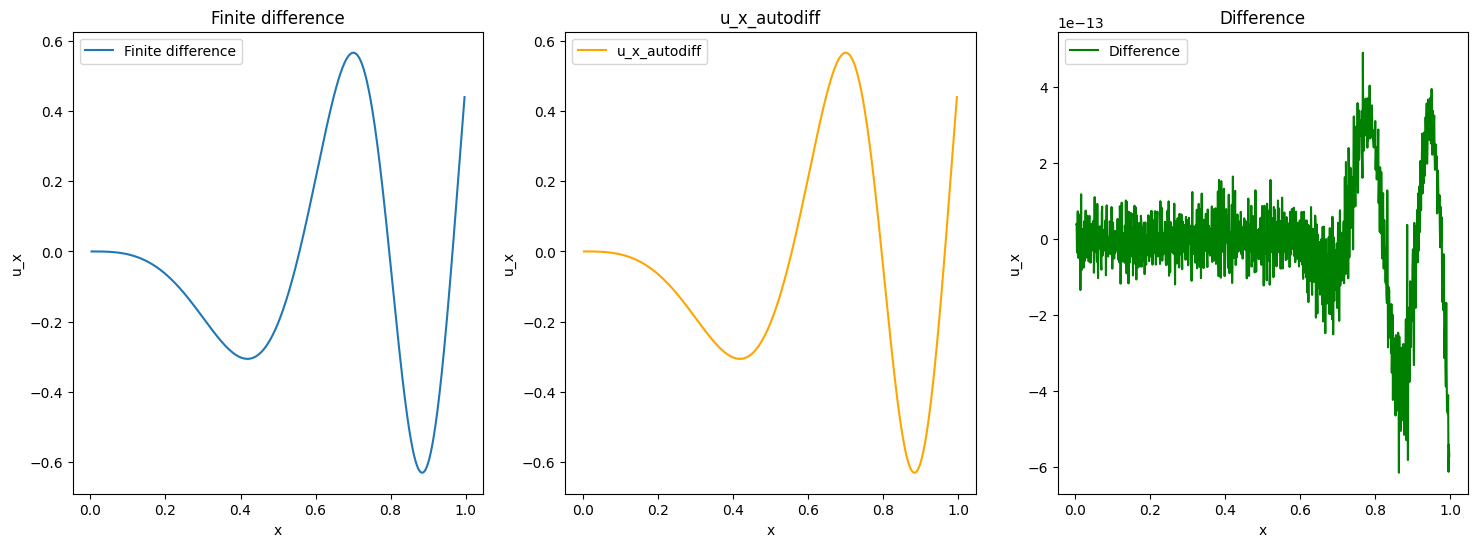

In [5]:
u_x_autodiff = u_x_autodiff2

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
axes[0].plot(x[3:-3], u_x_finite_diff, label='Finite difference')
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u_x')
axes[0].legend()

# Plot u_x_autodiff
axes[1].plot(x[3:-3], u_x_autodiff, label='u_x_autodiff', color='orange')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u_x')
axes[1].legend()

# Plot difference
axes[2].plot(x[3:-3], u_x_autodiff - u_x_finite_diff, label='Difference', color='green')
axes[2].set_title('Difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('u_x')
axes[2].legend()

plt.show()

# chatgpt

## jvp

In [6]:
@jax.custom_jvp
def network_with_grad(x):
    """
    Compute the forward pass of the network with a custom gradient defined.
    """
    ...
    v_Lm1_val = v_Lm1(x)  # (hidden_channels, x_points)
    v_L_val = v_L(v_Lm1_val)  # (hidden_channels, x_points)
    activation = activation_func(v_L_val)  # (hidden_channels, x_points)
    projected = projection(activation)[0]  # (x_points)
    return projected

@network_with_grad.defjvp
def network_jvp(primals, tangents):
    """
    Define the custom JVP rule for the network.
    """
    x, = primals
    x_dot, = tangents  # Tangent corresponds to dx/dx (for input `x`)

    # Forward pass
    ...
    v_Lm1_val = v_Lm1(x)  # (hidden_channels, x_points)
    v_L_val = v_L(v_Lm1_val)  # (hidden_channels, x_points)
    activation = activation_func(v_L_val)  # (hidden_channels, x_points)
    projected = projection(activation)[0]  # (x_points)

    # Custom gradient computation for dx/dx
    d_Q_d_v_L = jax.grad(lambda v: jnp.sum(projection(activation_func(v))))(v_L_val)  # (hidden_channels, x_points)
    d_v_L_dx = dv_L_dx(v_Lm1_val)  # (hidden_channels, x_points)
    d_projected_dx = (d_Q_d_v_L * d_v_L_dx).sum(axis=0)  # Chain rule for derivatives

    return projected, d_projected_dx * x_dot

@jax.jit
def dx_network3(x):
    return jax.grad(lambda x: jnp.sum(network_with_grad(x)))(x)

# Forward pass
output = network_with_grad(x)

# Compute derivative w.r.t. x
u_x_autodiff3 = dx_network3(x)[3:-3]

## vjp

In [9]:
@jax.custom_vjp
def network_with_vjp(x):
    """
    Forward computation of the network.
    """
    v_Lm1_val = v_Lm1(x)  # (hidden_channels, x_points)
    v_L_val = v_L(v_Lm1_val)  # (hidden_channels, x_points)
    activation = activation_func(v_L_val)  # (hidden_channels, x_points)
    projected = projection(activation)[0]  # (x_points)
    return projected, (v_Lm1_val, v_L_val)  # Save intermediate values for backward pass


# Forward and backward definitions
def network_fwd(x):
    """
    Forward pass returns output and saved values for the backward pass.
    """
    output, saved_intermediates = network_with_vjp(x)
    return output, saved_intermediates


def network_bwd(saved_intermediates, grad_output):
    """
    Backward pass computes the gradient using the chain rule.
    """
    v_Lm1_val, v_L_val = saved_intermediates

    # Gradient of Q with respect to v_L
    d_Q_d_v_L = jax.grad(lambda v: jnp.sum(projection(activation_func(v))))(v_L_val)  # (hidden_channels, x_points)

    # Gradient of v_L with respect to x
    d_v_L_dx = dv_L_dx(v_Lm1_val)  # (hidden_channels, x_points)

    # Chain rule: Combine gradients
    d_projected_dx = (d_Q_d_v_L * d_v_L_dx).sum(axis=0)  # Chain rule along axis=0

    # Multiply by the gradient from the output
    grad_input = d_projected_dx * grad_output  # (x_points)
    return (grad_input,)  # Gradients must be returned as a tuple


# Bind forward and backward passes to the custom_vjp
network_with_vjp.defvjp(network_fwd, network_bwd)

@jax.jit
def dx_network4(x):
    return jax.grad(lambda x: jnp.sum(network_with_vjp(x)))(x)

x = jnp.linspace(0.2, 3.4, 1000)
# Forward pass
output = network_with_vjp(x)

# Compute derivative w.r.t. x
start = time.perf_counter()
dx_output = dx_network4(x)
end = time.perf_counter()
print(f"Time taken: {end - start:.2f} seconds")

start = time.perf_counter()
dx_output = dx_network1(x)
end = time.perf_counter()
print(f"Time taken: {end - start:.2f} seconds")
# dx_output now contains the derivative of the network with respect to x.

Time taken: 0.14 seconds
Time taken: 0.09 seconds


In [9]:
x = jnp.linspace(0, 1, x_points)
dx_network1(x)
dx_network2(x)
dx_network3(x)
dx_network4(x)
x = jnp.linspace(0, 3, x_points)
network_with_vjp(x)

(Array([-0.25681837, -0.25681837, -0.25681837, -0.25681838, -0.25681841,
        -0.25681848, -0.25681859, -0.25681878, -0.25681906, -0.25681948,
        -0.25682006, -0.25682084, -0.25682187, -0.25682318, -0.25682484,
        -0.2568269 , -0.25682942, -0.25683245, -0.25683606, -0.25684033,
        -0.25684533, -0.25685114, -0.25685784, -0.25686552, -0.25687427,
        -0.25688418, -0.25689536, -0.2569079 , -0.25692191, -0.2569375 ,
        -0.2569548 , -0.2569739 , -0.25699494, -0.25701805, -0.25704334,
        -0.25707097, -0.25710105, -0.25713374, -0.25716918, -0.25720752,
        -0.2572489 , -0.25729349, -0.25734144, -0.25739291, -0.25744808,
        -0.2575071 , -0.25757015, -0.2576374 , -0.25770904, -0.25778524,
        -0.25786618, -0.25795206, -0.25804306, -0.25813936, -0.25824118,
        -0.25834869, -0.2584621 , -0.25858161, -0.25870742, -0.25883973,
        -0.25897874, -0.25912467, -0.25927771, -0.25943808, -0.25960598,
        -0.25978162, -0.25996521, -0.26015696, -0.2

In [10]:
%timeit jax.block_until_ready(dx_network1(x))

%timeit jax.block_until_ready(dx_network2(x))

%timeit jax.block_until_ready(dx_network3(x))

%timeit jax.block_until_ready(dx_network4(x))

141 μs ± 2.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
145 μs ± 3.27 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
146 μs ± 4.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
146 μs ± 3.04 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# MWE for custom chain rule on vector-valued functions, 2D

result (64, 1000)
u_x_finite_diff (64, 994)
u_x_autodiff (64, 994)


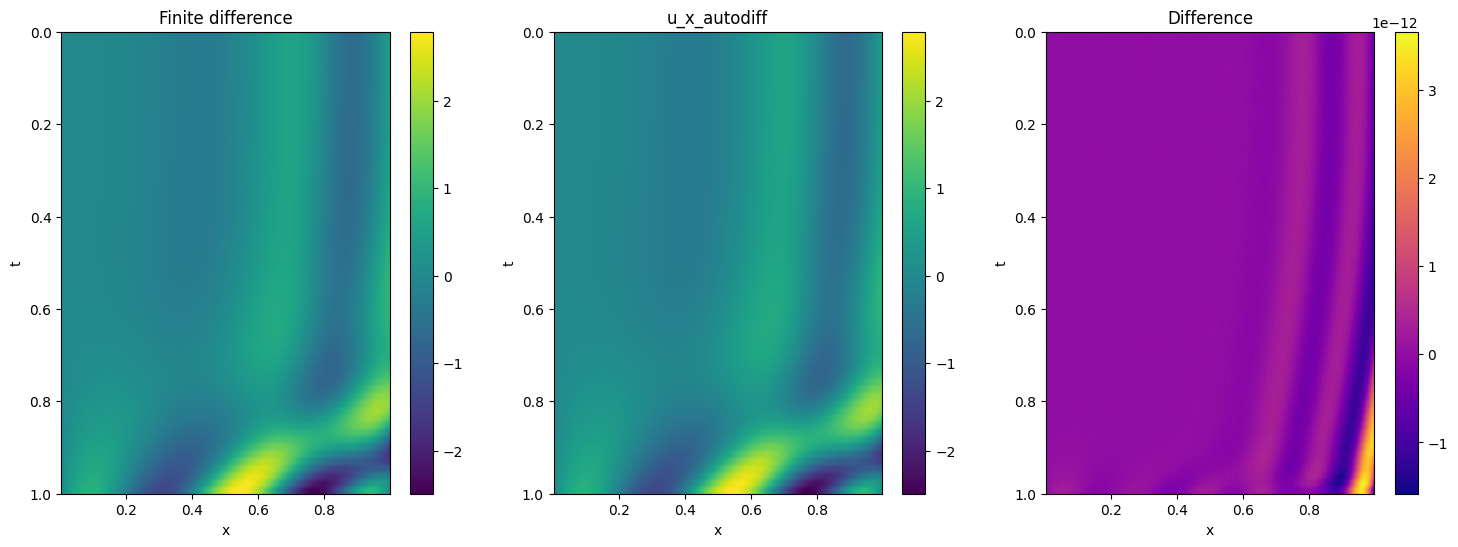

In [ ]:
hidden_channels = 5
x_points = 1000
t_points = 64
projection = eqx.nn.Conv2d(in_channels = hidden_channels, out_channels = 1, kernel_size = 1, key=random.key(0))
activation_func = lambda x : jnp.cos(x)
x = jnp.linspace(0, 1, x_points)
t = jnp.linspace(0, 1, t_points)

# Define v(x, t)
def v_Lm1(x, t):
    val1 = 1/3*x**2 + 2*t[:,None]**3*x
    val2 = 2/3*x**4 + 1.6*t[:,None]**2 * x**2
    val3 = 1/5*x**3 + 4.3*t[:,None]**2.3 * x
    val4 = 1/6*x**5 + 7.2*t[:,None]**3.2 * x
    val5 = 5*x**2 + 1.52*t[:,None]**2.4 * x
    return jnp.stack([val1, val2, val3, val4, val5])
    #return jnp.stack([val1 for _ in range(hidden_channels)])

def v_L(v_Lm1_val):
    return jnp.sin(v_Lm1_val) 

def dv_L_dx(v_Lm1_val):
    dval1 = 2/3*x + 2*t[:,None]**3
    dval2 = 8/3*x**3 + 1.6*t[:,None]**2*2*x
    dval3 = 3/5*x**2 + 4.3*t[:,None]**2.3
    dval4 = 5/6*x**4 + 7.2*t[:,None]**3.2
    dval5 = 10*x + 1.52*t[:,None]**2.4
    return jnp.cos(v_Lm1_val) * jnp.stack([dval1, dval2, dval3, dval4, dval5], axis=0)
    
    #return jnp.cos(v_Lm1_val) * jnp.stack([dval1 for _ in range(hidden_channels)])

# Full network
def network(x, t):
    v_Lm1_val = v_Lm1(x, t) # (hidden_channels, t_points, x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels, t_points, x_points)
    activation = activation_func(v_L_val) # (hidden_channels,t_points, x_points)
    projected = projection(activation)[0] # (t_points, x_points)
    return projected

"""
# old method
def dx_network(x):
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val)[:,None] # (hidden_channels,1)
        projected = projection(activation) # (1,1)
        return projected[0,0] #scalar
    
    # v_L_val is (hidden_channels,x_points)
    d_Q_d_v_L = jax.vmap(jax.grad(Q_of_v_L), in_axes=1, out_axes=1)(v_L_val) # (hidden_channels, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
"""
# uses sum method to compute d_Q_d_v_L
def dx_network(x, t):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x, t) # (hidden_channels,t_points, x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,t_points, x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val) # (hidden_channels, t_points, x_points)
        projected = projection(activation) # (hidden_channels, t_points, x_points)
        return jnp.sum(projected) #scalar
    
    # v_L_val is (hidden_channels,t_points, x_points)
    d_Q_d_v_L = jax.grad(Q_of_v_L)(v_L_val) # (hidden_channels, t_points, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,t_points, x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
    
result = network(x, t)

u_x_finite_diff = Dx(result, x[1]-x[0], axis=1, order=6)[:, 3:-3]
u_x_autodiff = dx_network(x, t)[:, 3:-3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]])
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_x_autodiff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]], cmap='viridis')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot difference
im3 = axes[2].imshow(u_x_autodiff - u_x_finite_diff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]], cmap='plasma')
axes[2].set_title('Difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

# Implementation for the actual FNO2d

## Import needed classes

In [7]:
import equinox as eqx
import jax.numpy as jnp
from typing import Callable, Optional
from jaxtyping import Array
from dataclasses import dataclass

@dataclass(kw_only=True, frozen=True)
class SAHparams:
    """Stores the hyperparameters for the self adaptive weights λ"""
    λ_learning_rate: float = None # learning rate for the self adaptive weights λ
    λ_optimizer: str = "adam" # optimizer to use for the self adaptive weights λ
    λ_mask: str = "soft_relu" # mask to apply to the λ-weights, before multiplying them with the loss
    λ_shape: tuple[int, ...] = (1,)

class SelfAdaptive(eqx.Module):
    """Module initializes and stores self adaptive weights for the network."""
    λ: Array #the actual self adaptive weights
    λ_mask: Callable #mask to apply to the λ-weights, before multiplying them with the loss
    
    def __init__(self, hparams : SAHparams):
        self.λ = jnp.ones(hparams.λ_shape)
        
        AVAILABLE_MASKS = {
            "soft_relu" : lambda λ: jnp.where(λ >= 1, λ, jnp.exp(λ-1)),
            "quadratic" : lambda λ: jnp.where(λ**2 >= 1, λ, jnp.exp(λ-1)),
            "sigmoid" : lambda λ: 2/(1+jnp.exp(5*(-λ+1))),
        }
        
        self.λ_mask = AVAILABLE_MASKS[hparams.λ_mask]
            
    def __call__(self, t_idx):
        return self.λ_mask(jnp.take(self.λ, t_idx))


In [8]:
from abc import ABC, abstractmethod
import equinox as eqx
from dataclasses import dataclass
from typing import Optional

class AbstractOperatorNet(eqx.Module, ABC):
	"""
	An abstract base class for all Operator Networks. 
	This defines the common interface for all OperatorNetwork types.
	"""
	self_adaptive: Optional[SelfAdaptive]
	is_self_adaptive: bool
 
	@abstractmethod
	def __init__(self, hparams):
		#checks whether the hparams for self-adaptive weights are set
		self.is_self_adaptive = hparams.λ_learning_rate is not None
		if self.is_self_adaptive:
			self.self_adaptive = SelfAdaptive(hparams)
		else:
			self.self_adaptive = None
   
		#checks whether the learning rate for the energy net is set
		"""
		has_energy_net = hparams.energy_learning_rate is not None 
		if has_energy_net:
			self.energy_net = EnergyNet(hparams)
		else:
			self.energy_Net = None
		"""

	@abstractmethod
	def __call__(self, a, x, t):
		"""Computes the prediction of the network"""
		pass

	@abstractmethod
	def predict_whole_grid(self, a, x, t):
		"""Not all operator nets take array input for x and t.
  		This function predicts over the whole grid"""
		pass
	
@dataclass(kw_only=True, frozen=True)
class AbstractHparams(SAHparams):#, EnergyHparams):
	"""Specifies the hyperparameters of an abstract network.
	These are parameters that are common to all networks.
	"""
	seed: int = 0 # seed for reproducibility
	batch_size: int = 16 # batch size
	learning_rate: float = 1e-3 # learning rate for the "regular" network parameters
	optimizer: str = "adam" # optimizer to use for the "regular" network parameters

# FNO2d class

In [139]:
from dataclasses import dataclass
from typing import Callable, Union
from jaxtyping import Array

@dataclass(kw_only=True, frozen=True)
class Hparams(AbstractHparams):
    # network parameters
    n_blocks: int # number of FNO blocks
    hidden_dim: int # dimension of the hidden layers
    modes_max: int # maximum number of modes to keep in the spectral convolutions
    
class Bypass(eqx.Module):
    weights: Array

    def __init__(self, in_channels, out_channels, key):
        init_std = jnp.sqrt(2.0 / in_channels)
        self.weights = random.normal(key, (out_channels, in_channels))*init_std

    def __call__(self, v):
        return jnp.tensordot(self.weights, v, axes=(1, 0))

class SpectralConv2d(eqx.Module):
    weights1: Array
    weights2: Array
    in_channels: int
    out_channels: int
    modes1: int
    modes2: int

    def __init__(self, in_channels, out_channels, modes1, modes2, key):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        subkey1, subkey2 = random.split(key, 2)
     
        init_std = jnp.sqrt(2.0 / (self.in_channels))
        
        self.weights1 = random.normal(subkey1, (self.in_channels, self.out_channels, self.modes1, self.modes2), dtype = jnp.complex64)*init_std
        self.weights2 = random.normal(subkey2, (self.in_channels, self.out_channels, self.modes1, self.modes2), dtype = jnp.complex64)*init_std

    def __call__(self, v):
        in_channels, points_x, points_y = v.shape

        # Fourier transform
        v_hat = jnp.fft.rfft2(v)
        
        # Multiply relevant Fourier modes
        out_hat_padded = jnp.zeros((self.out_channels, points_x, points_y//2 + 1), dtype = v_hat.dtype)
        out_hat_padded = out_hat_padded.at[:, :self.modes1 , :self.modes2].set(self.compl_mul2d(v_hat[:, :self.modes1 , :self.modes2], self.weights1))
        out_hat_padded = out_hat_padded.at[:, -self.modes1:, :self.modes2].set(self.compl_mul2d(v_hat[:, -self.modes1: , :self.modes2], self.weights2))

        # Return to physical space
        out = jnp.fft.irfft2(out_hat_padded, s=[points_x, points_y])

        return out
    
    def compl_mul2d(self, input, weights):
        # (in_channel, x, y), (in_channel, out_channel, x,y) -> (out_channel, x,y)
        return jnp.einsum("ixy,ioxy->oxy", input, weights)
    
    def Dx(self, v, dx):
        channels, Nt, Nx = v.shape

        # Compute 2D Fourier transform
        v_hat = jnp.fft.rfft2(v)
        
        out_hat_padded = jnp.zeros((self.out_channels, Nt, Nx//2 + 1), dtype = v_hat.dtype)
        out_hat_padded = out_hat_padded.at[:, :self.modes1 , :self.modes2].set(self.compl_mul2d(v_hat[:, :self.modes1 , :self.modes2], self.weights1))
        out_hat_padded = out_hat_padded.at[:, -self.modes1:, :self.modes2].set(self.compl_mul2d(v_hat[:, -self.modes1: , :self.modes2], self.weights2))

        # Apply differentiation in Fourier space
        kx = jnp.fft.rfftfreq(Nx, dx) * 2 * jnp.pi
        dx_hat = 1j * kx[None, :] * out_hat_padded

        # Transform back to physical space
        dx_val = jnp.fft.irfft2(dx_hat, s=(Nt, Nx))
        return dx_val
        
    def Dt(self, v, dt):
        channels, Nt, Nx = v.shape

        # Compute 2D Fourier transform
        v_hat = jnp.fft.rfft2(v)
        
        out_hat_padded = jnp.zeros((self.out_channels, Nt, Nx//2 + 1), dtype = v_hat.dtype)
        out_hat_padded = out_hat_padded.at[:, :self.modes1 , :self.modes2].set(self.compl_mul2d(v_hat[:, :self.modes1 , :self.modes2], self.weights1))
        out_hat_padded = out_hat_padded.at[:, -self.modes1:, :self.modes2].set(self.compl_mul2d(v_hat[:, -self.modes1: , :self.modes2], self.weights2))


        # Apply differentiation in Fourier space# Apply differentiation in Fourier space
        kt = jnp.fft.fftfreq(Nt, dt) * jnp.pi * 2 
        dt_hat = 1j * kt[:, None] * out_hat_padded

        # Transform back to physical space
        dt_val = jnp.fft.irfft2(dt_hat, s=(Nt, Nx))
        return dt_val
    
class FNOBlock2d(eqx.Module):
    spectral_conv: SpectralConv2d
    bypass: jax.Array
    activation: Callable
    
    def __init__(self, in_channels, out_channels, modes1, modes2, activation, key = random.key(0)):
        spectral_conv_key, bypass_key = jax.random.split(key)
        self.spectral_conv = SpectralConv2d(
            in_channels,
            out_channels,
            modes1,
            modes2,
            spectral_conv_key,
        )
        self.bypass = Bypass(in_channels, out_channels, bypass_key)
        self.activation = activation

    def __call__(self, v):
        return self.activation(self.spectral_conv(v) + self.bypass(v))

class FNO2d(AbstractOperatorNet):
    """Maps a function on a spatial-temporal domain to the solution on the same spatial-temporal domain.
    For the case where the input is an initial condition, the field a(x,t) is constant in time (=a(x)).
    
    Input: (a(x,t), x, t)
        Shapes:
            a(x,t): (m,)
            x: (m,)
            t: (n,)
    Outputs: u(x,t)
        Shapes:
            u(x,t): (n, m)
    """
    lifting: eqx.nn.Conv1d
    fno_blocks: FNOBlock2d
    final_fno_layer: SpectralConv2d
    activation: Callable
    projection: eqx.nn.Conv1d

    def __init__(self, hparams : Union[Hparams, dict]):
        if isinstance(hparams, dict):
            hparams = Hparams(**hparams)
        super().__init__(hparams)
        
        key = random.key(hparams.seed)
        keys = random.split(key, hparams.n_blocks + 2)
        
        self.lifting = eqx.nn.Conv2d(in_channels = 3, out_channels = hparams.hidden_dim, kernel_size = 1, key=keys[0])

        self.fno_blocks = eqx.filter_vmap(lambda key: FNOBlock2d(hparams.hidden_dim, hparams.hidden_dim, hparams.modes_max, hparams.modes_max, jax.nn.gelu, key=key))(keys[1:-2])
        
        self.final_fno_layer = SpectralConv2d(
            hparams.hidden_dim,
            hparams.hidden_dim,
            hparams.modes_max,
            hparams.modes_max,
            keys[-2],
        )
        
        self.activation = jax.nn.gelu
        
        self.projection = eqx.nn.Conv2d(in_channels = hparams.hidden_dim, out_channels = 1, kernel_size = 1, key=keys[-1])

    def __call__(self,a,x,t):
        # each row of "a(x,t)" is "a(x)"
        a_repeated = jnp.tile(a, (len(t), 1))
        # each row is "x"
        x_repeated, t_repeated = jnp.meshgrid(x, t)
        
        # stack the inputs, shape is (3, n, m)
        v = jnp.stack([a_repeated, x_repeated, t_repeated], axis=0)
        
        v = self.lifting(v)
        
        dynamic_fno_blocks, static_fno_blocks = eqx.partition(self.fno_blocks, eqx.is_array)
        
        def f(v, dynamic_fno_block):
            fno_block = eqx.combine(dynamic_fno_block, static_fno_blocks)
            return fno_block(v), None
        
        v, _ = jax.lax.scan(f, v, dynamic_fno_blocks)
        
        v = self.activation(self.final_fno_layer(v))
        v = self.projection(v)

        return v[0]
    
    def predict_whole_grid(self, a, x, t):
        """FNO2d predicts over the whole grid already."""
        return self(a,x,t)
    
    def get_self_adaptive(self):
        return self.self_adaptive
    
    def Dx(self, a, x, t):
        # each row of "a(x,t)" is "a(x)"
        a_repeated = jnp.tile(a, (len(t), 1))
        # each row is "x"
        x_repeated, t_repeated = jnp.meshgrid(x, t)
        
        # stack the inputs, shape is (3, n, m)
        v = jnp.stack([a_repeated, x_repeated, t_repeated], axis=0)
        
        v = self.lifting(v)
        
        dynamic_fno_blocks, static_fno_blocks = eqx.partition(self.fno_blocks, eqx.is_array)
        
        def f(v, dynamic_fno_block):
            fno_block = eqx.combine(dynamic_fno_block, static_fno_blocks)
            return fno_block(v), None
        
        v_Lm1, _ = jax.lax.scan(f, v, dynamic_fno_blocks)
        v_L = self.final_fno_layer(v_Lm1)
        
        # compute derivative of Q wrt v_L
        def Q_of_v_L(v_L_val):
            projected = self.projection(self.activation(v_L_val)) # (hidden_channels, t_points, x_points)
            return jnp.sum(projected) #scalar
        
        # v_L_val is (hidden_channels,t_points, x_points)
        d_Q_d_v_L = jax.grad(Q_of_v_L)(v_L) # (hidden_channels, t_points, x_points)

        # compute derivative of v_L wrt x 
        d_v_L_dx = self.final_fno_layer.Dx(v_Lm1, x[1]-x[0]) # (hidden_channels,t_points, x_points)
        
        #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
        return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
    
    def Dt(self, a, x, t):
        # each row of "a(x,t)" is "a(x)"
        a_repeated = jnp.tile(a, (len(t), 1))
        # each row is "x"
        x_repeated, t_repeated = jnp.meshgrid(x, t)
        
        # stack the inputs, shape is (3, n, m)
        v = jnp.stack([a_repeated, x_repeated, t_repeated], axis=0)
        
        v = self.lifting(v)
        
        dynamic_fno_blocks, static_fno_blocks = eqx.partition(self.fno_blocks, eqx.is_array)
        
        def f(v, dynamic_fno_block):
            fno_block = eqx.combine(dynamic_fno_block, static_fno_blocks)
            return fno_block(v), None
        
        v_Lm1, _ = jax.lax.scan(f, v, dynamic_fno_blocks)
        v_L = self.final_fno_layer(v_Lm1)
        
        # compute derivative of Q wrt v_L
        def Q_of_v_L(v_L_val):
            projected = self.projection(self.activation(v_L_val)) # (hidden_channels, t_points, x_points)
            return jnp.sum(projected) #scalar
        
        # v_L_val is (hidden_channels,t_points, x_points)
        d_Q_d_v_L = jax.grad(Q_of_v_L)(v_L) # (hidden_channels, t_points, x_points)

        # compute derivative of v_L wrt x 
        d_v_L_dx = self.final_fno_layer.Dt(v_Lm1, t[1]-t[0]) # (hidden_channels,t_points, x_points)
        
        #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
        return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)

## Create a network and load data

In [140]:
# Define hyperparameters
hparams = {
    'n_blocks': 4,
    'hidden_dim': 32,
    'modes_max': 16,
    'seed': 42,
    'batch_size': 16,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
}

# Create an instance of the FNO2d network
fno2d_network = FNO2d(hparams)

data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
problem = "kdv"

scaled_data = jnp.load(data_path + problem + "_scaled_data.npz")
a_train_s = jnp.array(scaled_data["a_train_s"])
u_train_s = jnp.array(scaled_data["u_train_s"])
a_val_s = jnp.array(scaled_data["a_val_s"])
u_val_s = jnp.array(scaled_data["u_val_s"])

x_train_s = jnp.array(scaled_data["x_train_s"])
t_train_s = jnp.array(scaled_data["t_train_s"])

data = jnp.load(data_path + problem + ".npz")

In [141]:
a = jnp.array(data["data"][0,0])
x = jnp.array(data["x"])
t = jnp.array(data["t"])

In [151]:
x = jnp.linspace(-1.2, 3, 1000)
t = jnp.linspace(-12, 1.5, 1000)
a = jnp.cos(x)

In [152]:
result = fno2d_network(a, x, t)

u_x_finite_diff = Dx(result, x[1]-x[0], axis=1, order=6)[:, 3:-3]
u_x_autodiff = fno2d_network.Dx(a, x, t)[:, 3:-3]

u_t_finite_diff = Dx(result, t[1]-t[0], axis=0, order=6)[3:-3, :]
u_t_autodiff = fno2d_network.Dt(a, x, t)[3:-3, :]

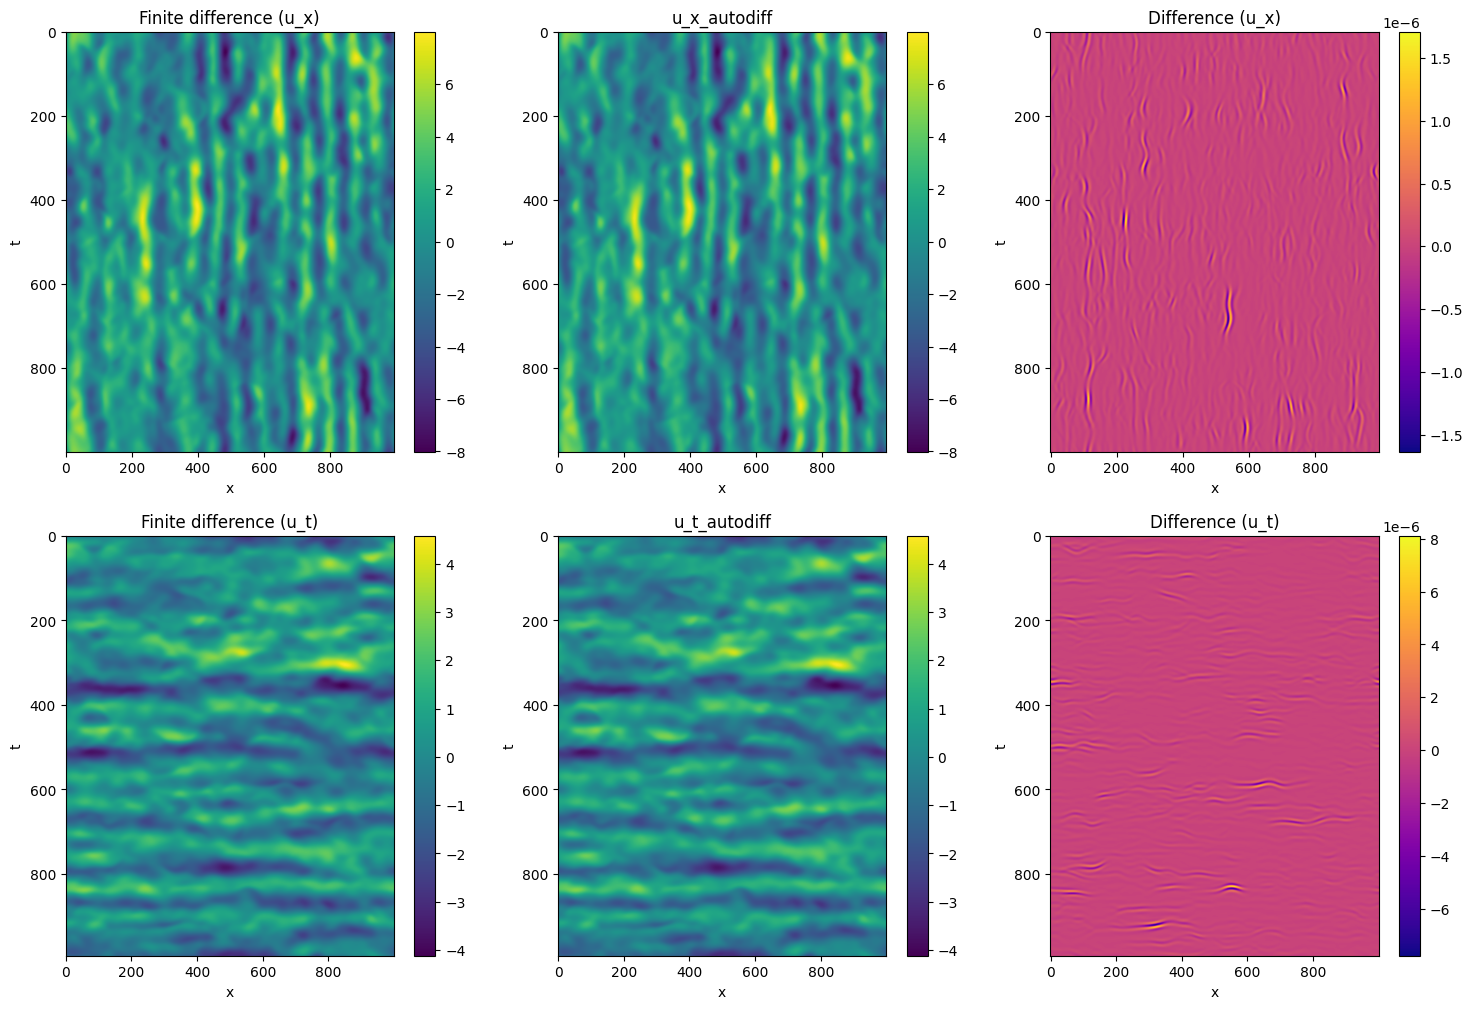

In [153]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot u_x_finite_diff
im1 = axes[0, 0].imshow(u_x_finite_diff, aspect='auto')
axes[0, 0].set_title('Finite difference (u_x)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0, 0])

# Plot u_x_autodiff
im2 = axes[0, 1].imshow(u_x_autodiff, aspect='auto', cmap='viridis')
axes[0, 1].set_title('u_x_autodiff')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('t')
fig.colorbar(im2, ax=axes[0, 1])

# Plot difference for u_x
im3 = axes[0, 2].imshow(u_x_autodiff - u_x_finite_diff, aspect='auto', cmap='plasma')
axes[0, 2].set_title('Difference (u_x)')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('t')
fig.colorbar(im3, ax=axes[0, 2])

# Plot u_t_finite_diff
im4 = axes[1, 0].imshow(u_t_finite_diff, aspect='auto')
axes[1, 0].set_title('Finite difference (u_t)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('t')
fig.colorbar(im4, ax=axes[1, 0])

# Plot u_t_autodiff
im5 = axes[1, 1].imshow(u_t_autodiff, aspect='auto', cmap='viridis')
axes[1, 1].set_title('u_t_autodiff')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('t')
fig.colorbar(im5, ax=axes[1, 1])

# Plot difference for u_t
im6 = axes[1, 2].imshow(u_t_autodiff - u_t_finite_diff, aspect='auto', cmap='plasma')
axes[1, 2].set_title('Difference (u_t)')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('t')
fig.colorbar(im6, ax=axes[1, 2])

plt.show()